## Predicting movie revenues with Machine Learning

The goal is to estimate a movie’s revenue using features that would be available before release (such as budget, genre, release year, and director track record).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

In [2]:
# Loading dataset
df = pd.read_csv("../data/processed/movies_corrected.csv")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (3228, 29)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,release_year,release_month,profit,roi,main_genre,cast_size,director_name
0,237000000.0,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2.787965e+09,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009,12,2.550965e+09,11.763566,Action,83,James Cameron
1,300000000.0,"['Adventure', 'Fantasy', 'Action']",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,9.610000e+08,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007,5,6.610000e+08,3.203333,Adventure,34,Gore Verbinski
2,245000000.0,"['Action', 'Adventure', 'Crime']",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,8.806746e+08,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015,10,6.356746e+08,3.594590,Action,83,Sam Mendes
3,250000000.0,"['Action', 'Crime', 'Drama', 'Thriller']",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1.084939e+09,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"['Christian Bale', 'Michael Caine', 'Gary Oldm...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",2012,7,8.349391e+08,4.339756,Action,158,Christopher Nolan
4,260000000.0,"['Action', 'Adventure', 'Science Fiction']",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,2.841391e+08,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2012,3,2.413910e+07,1.092843,Action,27,Andrew Stanton


### Feature engineering

In [3]:
df_model = df.copy()

# For budget - using the original values and log transform
df_model['log_budget'] = np.log1p(df_model['budget'])  # log(1+x) for handling 0

# Release decade
df_model['release_decade'] = (df_model['release_year'] // 10) * 10

# Genre one hot encoding
genre_dummies = pd.get_dummies(df_model['main_genre'], prefix='genre', dtype=float)
df_model = pd.concat([df_model, genre_dummies], axis=1)

# Director popularity - taken as actor's avg revenue
director_avg_rev = df_model.groupby('director_name')['revenue'].mean()
df_model['director_avg_revenue'] = df_model['director_name'].map(director_avg_rev)

features = ['budget', 'log_budget', 'release_year', 'release_decade',
            'director_avg_revenue'] + list(genre_dummies.columns)

X = df_model[features]  # features
y = df_model['revenue'] # target
y_log = np.log1p(y)  # log for stability

In [4]:
# Preview
X.head()

,budget,log_budget,release_year,release_decade,director_avg_revenue,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_Thriller,genre_War,genre_Western
0,237000000.0,19.283571,2009,2000,8.405099e+08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,300000000.0,19.519293,2007,2000,4.538591e+08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,245000000.0,19.316769,2015,2010,3.876498e+08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,250000000.0,19.336971,2012,2010,5.284354e+08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260000000.0,19.376192,2012,2010,5.272613e+08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
y_log.head()

0    21.748578
1    20.683485
2    20.596199
3    20.804790
4    19.464974
Name: revenue, dtype: float64

### Train/test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0) # 20% test, 80% training

print("training set:", X_train.shape)
print("testing set:", X_test.shape)

training set: (2582, 23)
testing set: (646, 23)


### First model: Linear Regression

Due to some errors encountered with NaNs while trying to do the linear regression, we first go back to checking whether any columns in df_model contain NaNs that could pose issues in the training process:

In [7]:
# NaNs per column
print(df_model.isna().sum())

budget                      0
genres                      0
homepage                 1881
id                          0
keywords                    0
original_language           0
original_title              0
overview                    0
popularity                  0
production_companies        0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline                   245
title                       0
vote_average                0
vote_count                  0
cast                        0
crew                        0
release_year                0
release_month               0
profit                      0
roi                         0
main_genre                  1
cast_size                   0
director_name               2
log_budget                  0
release_decade              0
genre_Action                0
genre_Adventure             0
genre_Anim

There seem to be two movies without director names, which is the direct cause of the 2 NaNs in the director_average_revenue column. 

In [8]:
print(df_model.loc[df_model['director_avg_revenue'].isna(), 'title'])

3030    The Book of Mormon Movie, Volume 1: The Journey
3040                                     Roadside Romeo
Name: title, dtype: object


Since these are only two titles, they should not influence the overall training process too much, we simply drop them.

In [9]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Training the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.3f}")
print(f"Linear Regression R²: {r2:.3f}")

Linear Regression RMSE: 1.397
Linear Regression R²: 0.472


Predictions vs actual values:

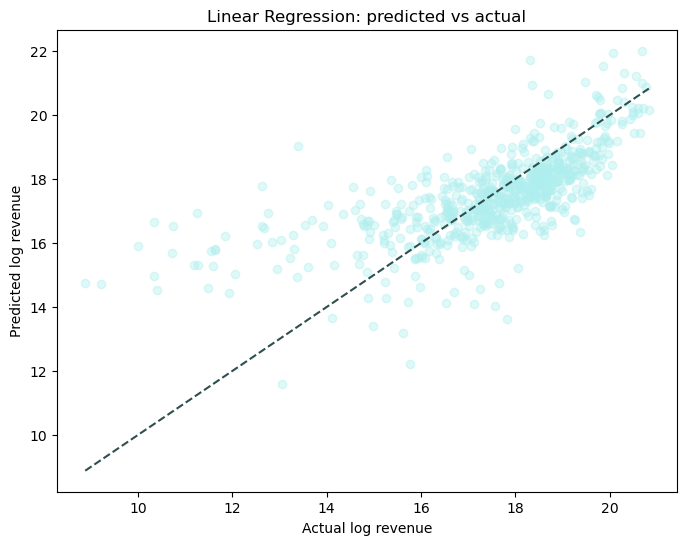

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4, color='paleturquoise')
plt.xlabel("Actual log revenue")
plt.ylabel("Predicted log revenue")
plt.title("Linear Regression: predicted vs actual")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='darkslategray', linestyle='dashed') 
plt.show()

**Observations:**  
The model generally captures overall trends, but tends to overestimate revenue for lower-grossing movies.  
This behavior might occur because linear regression minimizes global squared error, so extreme high-revenue movies pull the predictions upward. The feature set is also limited, so it might not capture the factors that drive very low revenue.

## Random Forest Regressor

In [13]:
# Finding optimal features
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

forest_tuning = RandomForestRegressor(random_state=0)
param_grid = {
   'n_estimators': [200, 500, 800],
   'max_depth' : [7, 9, 11],
}
GSCV = GridSearchCV(estimator=forest_tuning, param_grid=param_grid, cv=3, n_jobs=-1, verbose=4)
GSCV.fit(X_train, y_train)
print(GSCV.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 7, 'n_estimators': 500}


In [14]:
# Training the model
rf = RandomForestRegressor(n_estimators=500, max_depth=7, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest RMSE: {rmse_rf:.3f}")

Random Forest RMSE: 0.955


We notice lower RMSE than with the Linear Regression model (around 1.4).

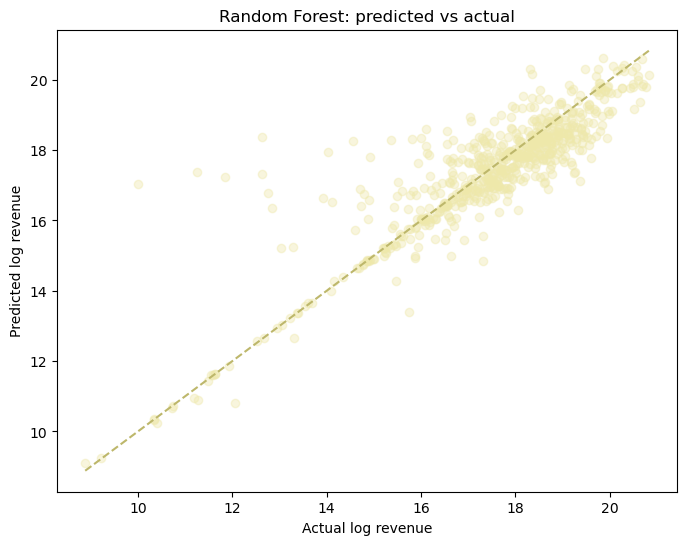

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.4, color="palegoldenrod")
plt.xlabel("Actual log revenue")
plt.ylabel("Predicted log revenue")
plt.title("Random Forest: predicted vs actual")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="darkkhaki", linestyle="dashed") 
plt.show()

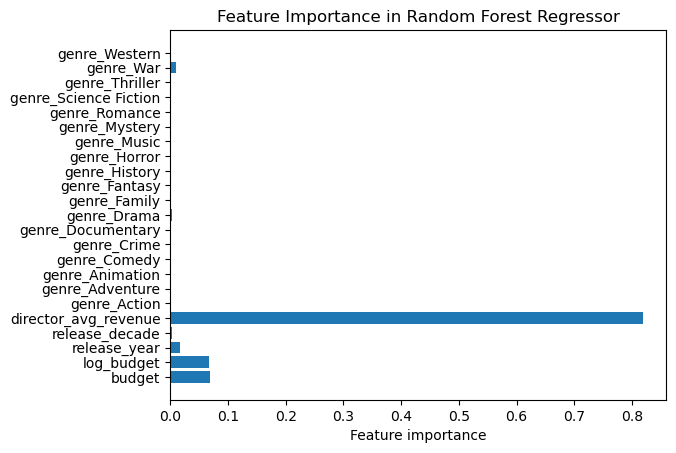

In [16]:
feature_importances = rf.feature_importances_

plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature importance')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

**Observations:**  
The Random Forest model outperforms Linear Regression on this dataset. RMSE is lower than in the linear regression baseline. The "predicted vs actual" plot shows much better alignment, especially for lower-revenue movies, where the linear model tended to overestimate.  

Feature importance analysis highlights that director average revenue is the most influential predictor (importance > 0.8), budget and release year are the next most important features, and genres generally contribute little (at the level of 0.01) - though "Drama" and "War" show relatively higher predictive power compared to others.  

## Gradient Boosting Regressor

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

# Training
gb = GradientBoostingRegressor(random_state=0, n_estimators=200, learning_rate=0.1, max_depth=10, verbose=4)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1           2.7164            2.03s
         2           2.2715            2.08s
         3           1.9087            2.02s
         4           1.6135            1.96s
         5           1.3707            1.72s
         6           1.1691            1.99s
         7           1.0011            2.05s
         8           0.8622            2.07s
         9           0.7493            1.86s
        10           0.6548            1.96s
        11           0.5766            1.77s
        12           0.5122            1.86s
        13           0.4588            1.71s
        14           0.4114            1.79s
        15           0.3732            1.66s
        16           0.3384            1.73s
        17           0.3104            1.78s
        18           0.2840            1.68s
        19           0.2637            1.73s
        20           0.2459            1.63s
        21           0.2284            1.68s
        2

Gradient Boosting RMSE: 1.066


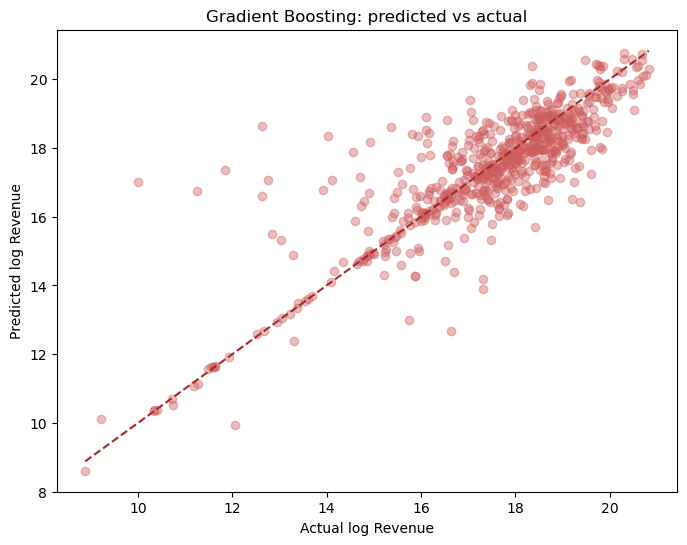

In [26]:
# Metrics
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f"Gradient Boosting RMSE: {rmse_gb:.3f}")

# Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_gb, alpha=0.4, color="indianred")
plt.xlabel("Actual log Revenue")
plt.ylabel("Predicted log Revenue")
plt.title("Gradient Boosting: predicted vs actual")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="brown", linestyle="dashed")
plt.show()

**Observations:**  
The Gradient Boosting model achieved an RMSE of ~1.07 (better than Linear Regression (1.40) but slightly worse than Random Forest (0.96)).  
The predicted vs. actual plot is visually similar to the Random Forest results, suggesting that the current set of features does not provide enough weak signals for Gradient Boosting to outperform.  

Gradient Boosting builds trees sequentially, with each new tree correcting residual errors. Because the dataset has relatively few features, this model to overfit quickly rather than uncover new predictive patterns.